In [1]:
%%pyspark
blob_account_name = "contosolakejj"
blob_container_name = "users"
from pyspark.sql import SparkSession

sc = SparkSession.builder.getOrCreate()
token_library = sc._jvm.com.microsoft.azure.synapse.tokenlibrary.TokenLibrary
blob_sas_token = token_library.getConnectionString("AzureBlobStorage1")

spark.conf.set(
    'fs.azure.sas.%s.%s.blob.core.windows.net' % (blob_container_name, blob_account_name),
    blob_sas_token)
df = spark.read.load('wasbs://users@contosolakejj.blob.core.windows.net/train.csv', format='csv', header=True)
display(df.limit(10))


StatementMeta(apachejj, 6, 2, Finished, Available)

SynapseWidget(Synapse.DataFrame, 1a63b500-f985-42cf-8b1c-2a1b536bb8a3)

Transformación de datos

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lower, trim
from pyspark.sql.types import IntegerType, DoubleType

# Convertir columnas a tipos numéricos
df = df.withColumn("PassengerId", df["PassengerId"].cast(IntegerType())) \
       .withColumn("Survived", df["Survived"].cast(IntegerType())) \
       .withColumn("Pclass", df["Pclass"].cast(IntegerType())) \
       .withColumn("SibSp", df["SibSp"].cast(IntegerType())) \
       .withColumn("Parch", df["Parch"].cast(IntegerType())) \
       .withColumn("Age", df["Age"].cast(DoubleType())) \
       .withColumn("Fare", df["Fare"].cast(DoubleType()))

# Asegurándonos de que la columna 'Sex' sea minúscula y sin espacios extra antes de la comparación
df = df.withColumn('Sex', trim(lower(col('Sex'))))
df = df.withColumn('Sex', F.when(col('Sex') == 'female', 0).otherwise(1))
# Para manejar valores faltantes en 'Age', podríamos imputarlos o eliminar las filas.
# Por ejemplo, para imputar la edad con la media (esto es solo un ejemplo, debes decidir la mejor estrategia):
age_mean = df.select(F.mean('Age')).collect()[0][0]
df = df.na.fill({'Age': age_mean})

# Mostrar un resumen de los datos
df.printSchema()

StatementMeta(apachejj, 6, 3, Finished, Available)

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: integer (nullable = false)
 |-- Age: double (nullable = false)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [3]:
display(df.limit(10))

StatementMeta(apachejj, 6, 4, Finished, Available)

SynapseWidget(Synapse.DataFrame, 6192e09e-e46f-4db7-8f16-98cf07df9809)

EDA

In [4]:
df.groupBy('Pclass').count().show()

StatementMeta(apachejj, 6, 5, Finished, Available)

In [5]:
df.stat.corr('Age', 'Fare') #Age and Fare

StatementMeta(apachejj, 6, 6, Finished, Available)

0.09156609328505748

StatementMeta(apachejj, 6, 7, Finished, Available)

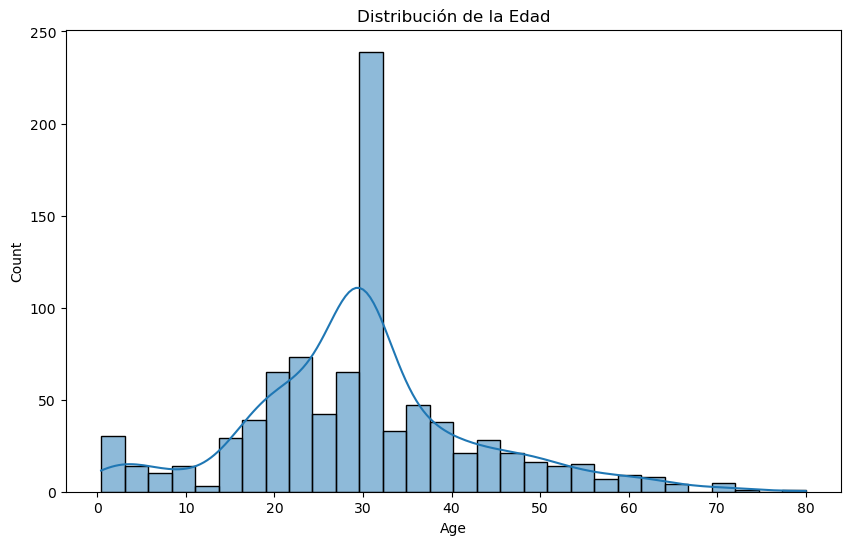

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir a pandas DataFrame
pandas_df = df.toPandas()

# Visualizar la distribución de la edad
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['Age'], kde=True)
plt.title('Distribución de la Edad')
plt.show()

StatementMeta(apachejj, 6, 9, Finished, Available)

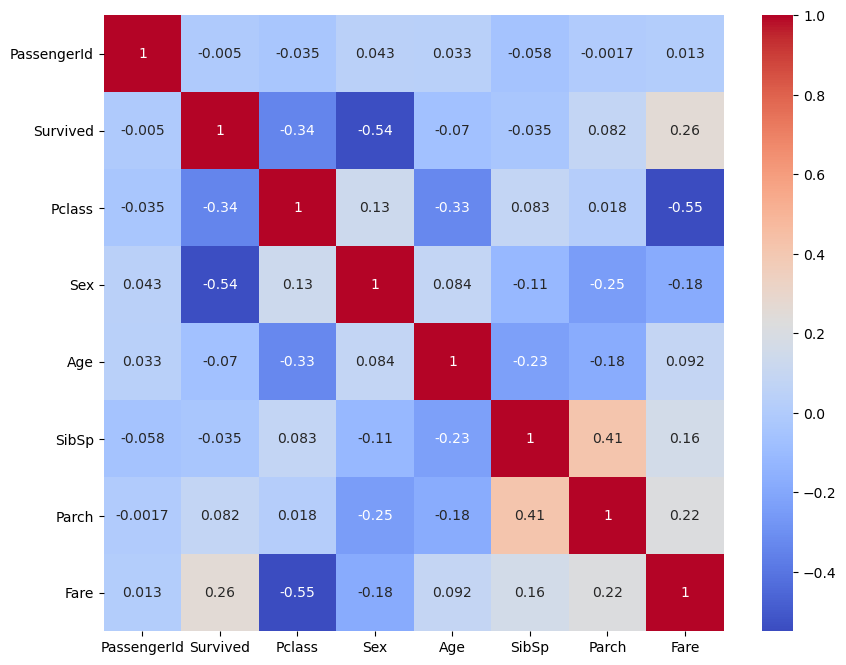

In [8]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

# Lista de columnas numéricas para incluir en el cálculo de correlación
numeric_columns = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

# Convertir las columnas numéricas en un vector
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# Calcular la matriz de correlación
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

# Convertir la matriz de correlación en un DataFrame de Pandas
# Nota: El siguiente paso de conversión a pandas y visualización debe realizarse en un entorno Python con pandas instalado

# Convertir a un DataFrame de pandas para una visualización más fácil
# Suponiendo que `matrix` es un objeto DenseMatrix que se puede convertir a un array numpy
corr_df = pd.DataFrame(matrix.toArray())

# Nombra las columnas y los índices de acuerdo a las columnas numéricas
corr_df.columns = numeric_columns
corr_df.index = numeric_columns

# A continuación, visualizarías la matriz de correlación usando Seaborn o Matplotlib
# Esto debería ejecutarse en un entorno de Jupyter Notebook con estas librerías instaladas
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.show()


In [9]:
df.groupBy('Pclass').agg({'Survived': 'mean'}).show() #Pclass
df.groupBy('Sex').agg({'Survived': 'mean'}).show() #Sex

StatementMeta(apachejj, 6, 10, Finished, Available)

+------+-------------------+
|Pclass|      avg(Survived)|
+------+-------------------+
|     1| 0.6296296296296297|
|     3|0.24236252545824846|
|     2|0.47282608695652173|
+------+-------------------+

+---+-------------------+
|Sex|      avg(Survived)|
+---+-------------------+
|  1|0.18890814558058924|
|  0| 0.7420382165605095|
+---+-------------------+



StatementMeta(apachejj, 6, 11, Finished, Available)

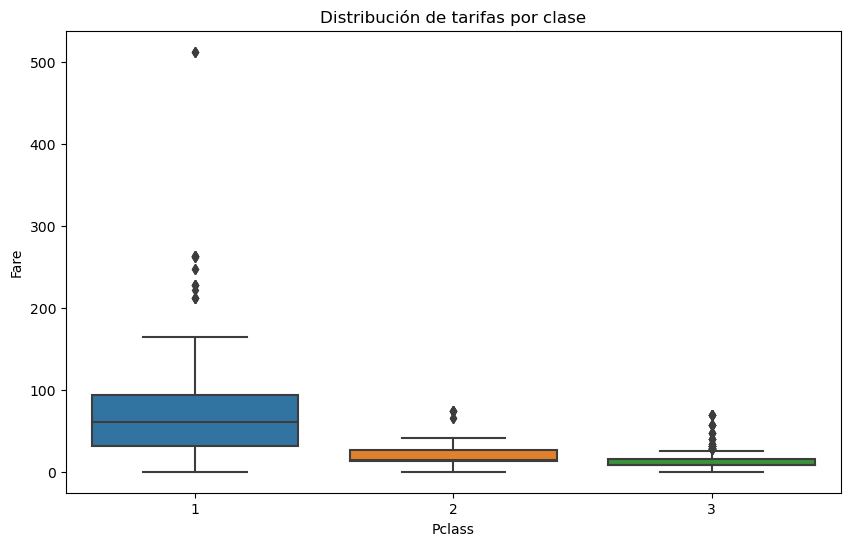

In [10]:
pandas_df = df.toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Fare', data=pandas_df) #Pclass, Fare
plt.title('Distribución de tarifas por clase')
plt.show()

StatementMeta(apachejj, 6, 12, Finished, Available)

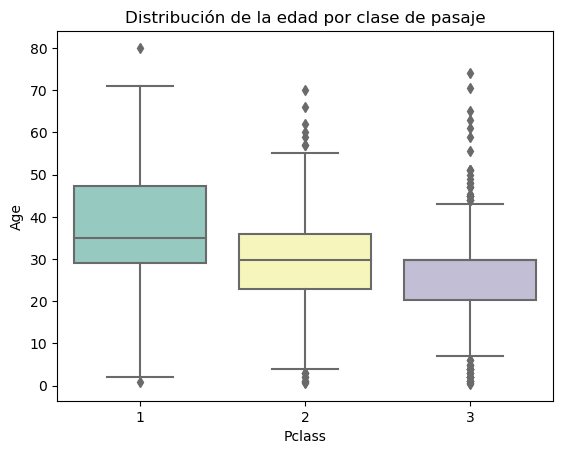

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Pclass', y='Age', data=df.toPandas(), palette='Set3')
plt.title('Distribución de la edad por clase de pasaje')
plt.show()

StatementMeta(apachejj, 6, 13, Finished, Available)

/home/trusted-service-user/cluster-env/env/lib/python3.10/site-packages/seaborn/distributions.py:244: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


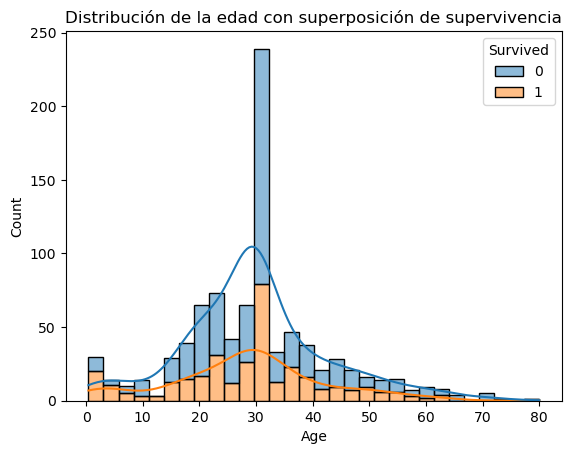

In [12]:
sns.histplot(data=df.toPandas(), x='Age', kde=True, hue='Survived', multiple='stack')
plt.title('Distribución de la edad con superposición de supervivencia')
plt.show()

StatementMeta(apachejj, 6, 14, Finished, Available)

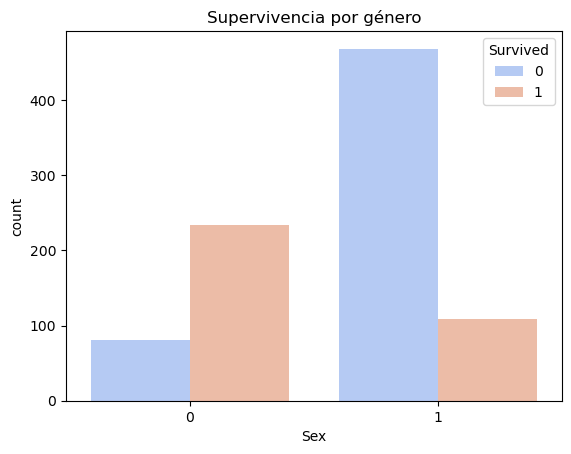

In [13]:
sns.countplot(x='Sex', hue='Survived', data=df.toPandas(), palette='coolwarm')
plt.title('Supervivencia por género')
plt.show()

StatementMeta(apachejj, 6, 15, Finished, Available)

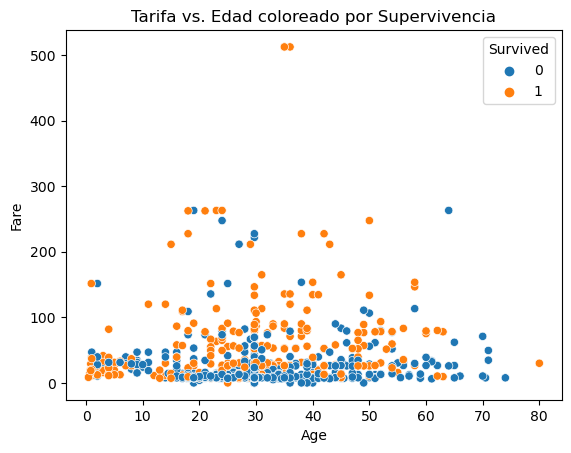

In [14]:
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=df.toPandas())
plt.title('Tarifa vs. Edad coloreado por Supervivencia')
plt.show()

StatementMeta(apachejj, 6, 16, Finished, Available)

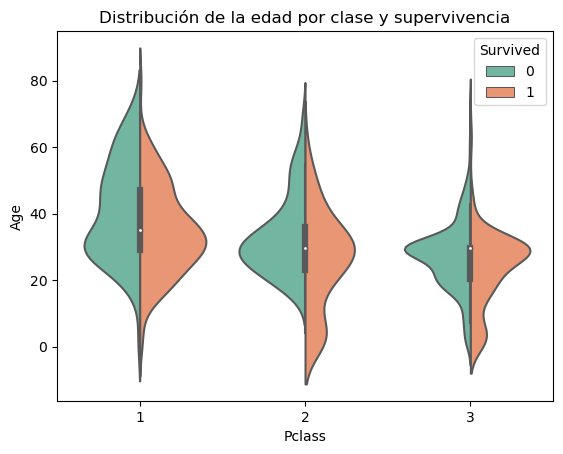

In [15]:
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=df.toPandas(), split=True, palette='Set2')
plt.title('Distribución de la edad por clase y supervivencia')
plt.show()

StatementMeta(apachejj, 6, 17, Finished, Available)

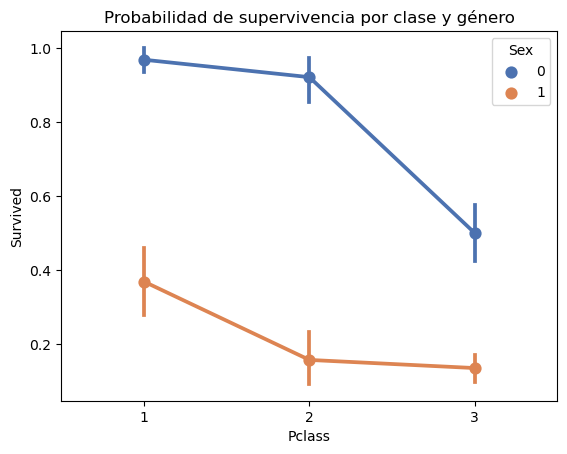

In [16]:
sns.pointplot(x='Pclass', y='Survived', hue='Sex', data=df.toPandas(), palette='deep')
plt.title('Probabilidad de supervivencia por clase y género')
plt.show()

StatementMeta(apachejj, 6, 18, Finished, Available)

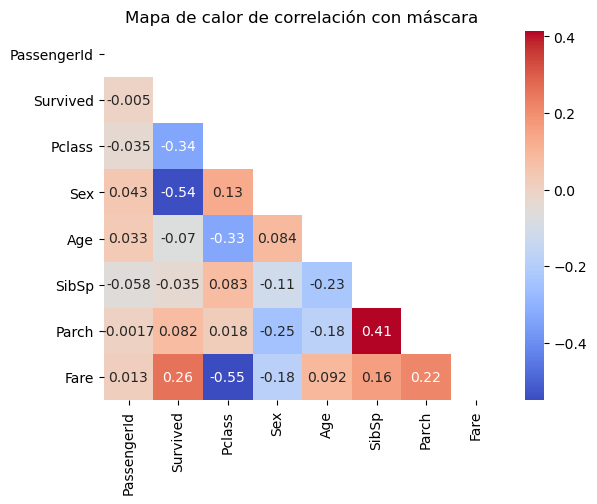

In [17]:
import numpy as np
# Asumiendo que corr_df es el DataFrame de pandas con la matriz de correlación
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, mask=mask, cmap='coolwarm', annot=True)
plt.title('Mapa de calor de correlación con máscara')
plt.show()

# SNA

In [18]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Función para extraer el apellido de la columna 'Name'
def extract_surname(name):
    return name.split(',')[0].strip()

extract_surname_udf = udf(extract_surname, StringType())

# Aplicar la UDF para crear una nueva columna 'Surname'
df = df.withColumn('Surname', extract_surname_udf(df['Name']))

# Agrupar por apellido y número de ticket para encontrar familias
family_groups = df.groupBy('Surname', 'Ticket').agg(
    F.count('PassengerId').alias('FamilySize'),
    F.sum('Survived').alias('FamilySurvived'),
    F.avg('Survived').alias('FamilySurvivalRate')
)

# Encontrar pasajeros que viajaban solos para comparar
solo_passengers = family_groups.filter(family_groups['FamilySize'] == 1)

# Ahora puedes hacer un join con el DataFrame original si quieres agregar la información de tamaño de familia
df_with_family_info = df.join(family_groups, ['Surname', 'Ticket'], 'left')

# Mostrar los resultados
df_with_family_info.select(['PassengerId', 'Surname', 'Ticket', 'FamilySize', 'FamilySurvived', 'FamilySurvivalRate']).show()


StatementMeta(apachejj, 6, 19, Finished, Available)

+-----------+-------------+----------------+----------+--------------+------------------+
|PassengerId|      Surname|          Ticket|FamilySize|FamilySurvived|FamilySurvivalRate|
+-----------+-------------+----------------+----------+--------------+------------------+
|          1|       Braund|       A/5 21171|         1|             0|               0.0|
|          2|      Cumings|        PC 17599|         1|             1|               1.0|
|          3|    Heikkinen|STON/O2. 3101282|         1|             1|               1.0|
|          4|     Futrelle|          113803|         2|             1|               0.5|
|          5|        Allen|          373450|         1|             0|               0.0|
|          6|        Moran|          330877|         1|             0|               0.0|
|          7|     McCarthy|           17463|         1|             0|               0.0|
|          8|      Palsson|          349909|         4|             0|               0.0|
|         

StatementMeta(apachejj, 6, 20, Finished, Available)

/home/trusted-service-user/cluster-env/env/lib/python3.10/site-packages/seaborn/distributions.py:244: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


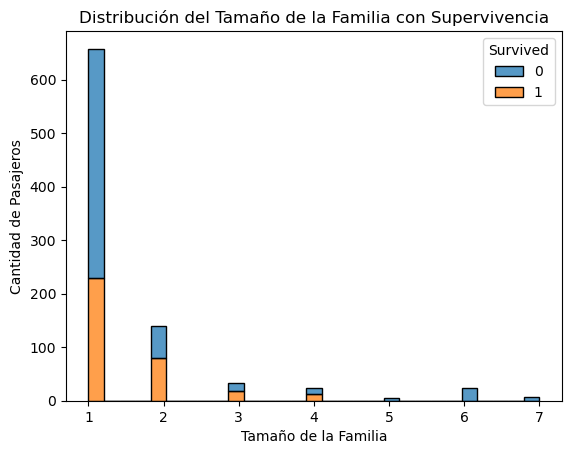

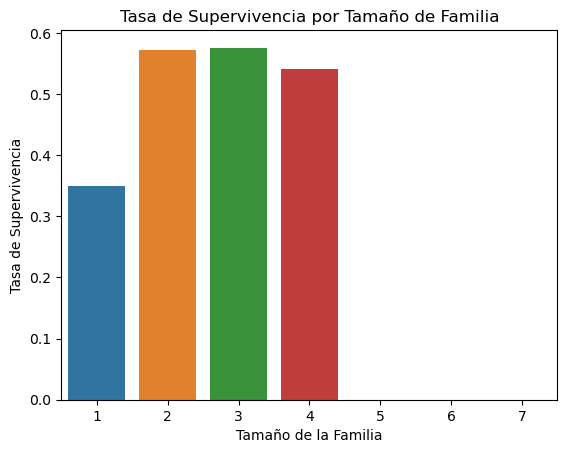

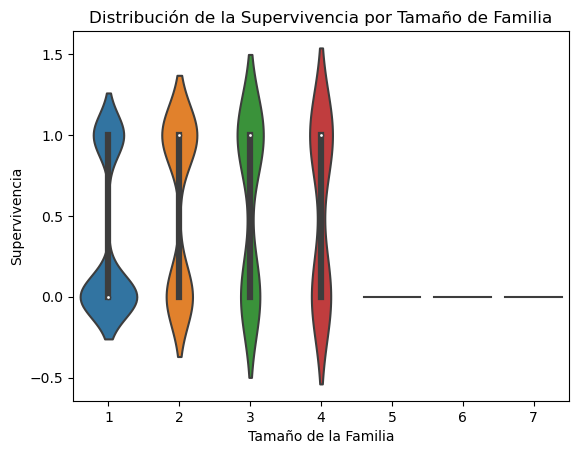

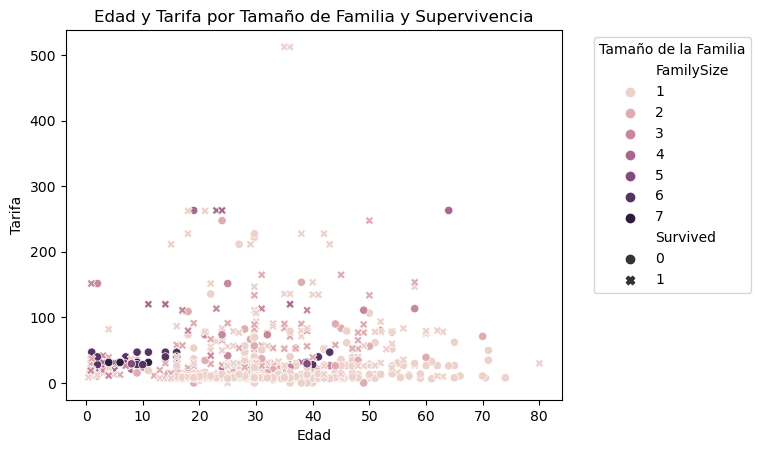

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegúrate de que estás trabajando con un DataFrame de Pandas
# Si df_with_family_info es un DataFrame de Spark, primero conviértelo con .toPandas()
df_family = df_with_family_info.toPandas()

# Histograma de tamaños de familia
sns.histplot(data=df_family, x='FamilySize', hue='Survived', multiple='stack')
plt.title('Distribución del Tamaño de la Familia con Supervivencia')
plt.xlabel('Tamaño de la Familia')
plt.ylabel('Cantidad de Pasajeros')
plt.show()

# Gráfico de barras de tasas de supervivencia por tamaño de familia
family_survival_rate = df_family.groupby('FamilySize')['Survived'].mean().reset_index()
sns.barplot(data=family_survival_rate, x='FamilySize', y='Survived')
plt.title('Tasa de Supervivencia por Tamaño de Familia')
plt.xlabel('Tamaño de la Familia')
plt.ylabel('Tasa de Supervivencia')
plt.show()

# Para un análisis más detallado, considera crear gráficos de puntos o gráficos de violín
# para examinar la distribución de las tasas de supervivencia dentro de cada tamaño de familia
sns.violinplot(data=df_family, x='FamilySize', y='Survived')
plt.title('Distribución de la Supervivencia por Tamaño de Familia')
plt.xlabel('Tamaño de la Familia')
plt.ylabel('Supervivencia')
plt.show()

# Otra opción podría ser un gráfico de dispersión que muestre la edad y la tarifa pagada,
# coloreado por tamaño de familia y estilo por supervivencia
sns.scatterplot(data=df_family, x='Age', y='Fare', hue='FamilySize', style='Survived')
plt.title('Edad y Tarifa por Tamaño de Familia y Supervivencia')
plt.xlabel('Edad')
plt.ylabel('Tarifa')
plt.legend(title='Tamaño de la Familia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [23]:
%%pyspark
from pyspark.sql import SparkSession

# Configuración inicial igual que antes
blob_account_name = "contosolakejj"
blob_container_name = "users"

# Obtener la sesión Spark existente
sc = SparkSession.builder.getOrCreate()

# Acceder al token SAS a través de la biblioteca de tokens en Azure Synapse
token_library = sc._jvm.com.microsoft.azure.synapse.tokenlibrary.TokenLibrary
blob_sas_token = token_library.getConnectionString("AzureBlobStorage1")

# Configurar el entorno para apuntar al blob storage
spark.conf.set(
    'fs.azure.sas.%s.%s.blob.core.windows.net' % (blob_container_name, blob_account_name),
    blob_sas_token
)

# Definir la ruta de salida dentro de Azure Data Lake Storage Gen2
output_path = f"abfss://{blob_container_name}@{blob_account_name}.dfs.core.windows.net/output/family_info"

# Guardar el DataFrame en formato Parquet en Azure Data Lake Storage Gen2
df_with_family_info.write.mode('overwrite').parquet(output_path)

print(f"DataFrame guardado con éxito en {output_path}")


StatementMeta(apachejj, 6, 24, Finished, Available)

DataFrame guardado con éxito en abfss://users@contosolakejj.dfs.core.windows.net/output/family_info
